# 哈尔滨工业大学（深圳）《统计机器学习》2023 春 实验一

<!-- | 学号      | 姓名   |
| --------- | ------ |
| 210810311 | 秦泽钊 | -->

<!-- 运行截图用 Notebook PDF 输出自带代码和输出代替。 -->

<!-- --- -->


In [1]:
#| echo: false

# 切换为矢量图
import matplotlib_inline
%matplotlib inline
matplotlib_inline.backend_inline.set_matplotlib_formats("svg")


## 实验分析

本次实验的目标是纯 Python 实现一个感知机模型，并用它解决经典的鸢尾花分类问题。使用 `sklearn.datasets` 中的鸢尾花数据集，将其分为训练集和测试集，训练集用于训练感知机模型，测试集用于评估模型的性能。


In [2]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.datasets import load_iris

iris = load_iris()
# help(iris)


In [3]:
print(iris.data.shape)
print(iris.target.shape)
print(iris.target)
print(iris.target_names)
print(iris.feature_names)


(150, 4)
(150,)
[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 2 2 2 2 2 2 2 2 2 2 2
 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2
 2 2]
['setosa' 'versicolor' 'virginica']
['sepal length (cm)', 'sepal width (cm)', 'petal length (cm)', 'petal width (cm)']


由输出可知，我们需要从 “sepal”（花萼）和 “petal”（花瓣）的两项测量值预测出一个 0..=2 的分类，首先我们对数据转成 Pandas 的 `DataFrame`，然后用 seaborn 绘制散点图，观察数据的分布情况。


In [4]:
#| label: tbl-iris
#| tbl-cap: 鸢尾花数据

df = pd.DataFrame(iris.data, columns=iris.feature_names)
df['target'] = iris.target
# df['target_name'] = df['target'].apply(lambda x: iris.target_names[x])

df


,sepal length (cm),sepal width (cm),petal length (cm),petal width (cm),target
0,5.1,3.5,1.4,0.2,0
1,4.9,3.0,1.4,0.2,0
2,4.7,3.2,1.3,0.2,0
3,4.6,3.1,1.5,0.2,0
4,5.0,3.6,1.4,0.2,0
...,...,...,...,...,...
145,6.7,3.0,5.2,2.3,2
146,6.3,2.5,5.0,1.9,2
147,6.5,3.0,5.2,2.0,2
148,6.2,3.4,5.4,2.3,2


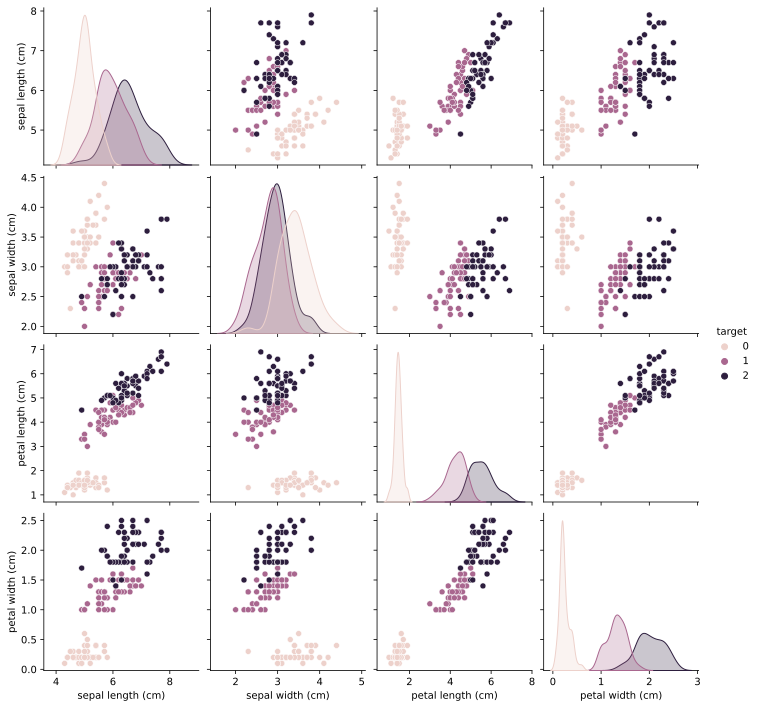

In [5]:
# | label: fig-pairplot
# | fig-cap: "鸢尾花属性两两配对的散点图"

sns.pairplot(df, hue='target')


可以看出，虽然 “versicolor” 和 “virginica” 之间有严重重叠，但是 “setosa” 和其他两个品种之间的分布还是比较明显的。尽管直方图显示，通过 petal 的其中一个特征即可区分 “setosa” 和 “virginica” 两个品种，本次实验选用 “petal length (cm)” 和 “petal width (cm)” 两个特征。


## Python 自编程实现感知机

首先，我们需要根据 “target” 列仅选出 “setosa” 和 “virginica” 两个品种的数据，然后将 “target” 列中的数字 0 和 2 分别替换为 -1 和 1。


In [6]:
#| label: tbl-iris-extracted
#| tbl-cap: 鸢尾花数据（用于训练感知机的子集）

training_targets = [0, 2]
data = df[iris.feature_names[2:4]+['target']
          ][df['target'].isin(training_targets)]
data['target'] = data['target'].apply(
    lambda x: 1 if x == training_targets[0] else -1)

data


,petal length (cm),petal width (cm),target
0,1.4,0.2,1
1,1.4,0.2,1
2,1.3,0.2,1
3,1.5,0.2,1
4,1.4,0.2,1
...,...,...,...
145,5.2,2.3,-1
146,5.0,1.9,-1
147,5.2,2.0,-1
148,5.4,2.3,-1


接下来定义感知机类，各个方法的功能见注释。


In [7]:
from typing import Optional


class MyPerceptron:
    def __init__(self,
                 x_len: int,
                 w_0: np.ndarray = None,
                 b_0: float = None,
                 l_rate: float = None) -> None:
        """
        构造感知机
        :param x_len: 特征的向量长度
        :param w_0: w 的初始值，默认为零向量
        :param b_0: b 的初始值，默认为 0
        """
        w_0 = np.ones(x_len, np.float32) if w_0 is None else w_0
        b_0 = 0 if b_0 is None else b_0

        self.w = w_0
        self.b = b_0
        self.l_rate = 0.01 if l_rate is None else l_rate

    def infer(self, x):
        """
        进行单次推理
        a.k.a. 算出 $\sgn(x \dot w + b)$
        """
        return np.sign(np.dot(x, self.w) + self.b)

    def fit(self,
            train_df: pd.DataFrame,
            validate_df: Optional[pd.DataFrame] = None,
            max_iter=100) -> tuple[int, float, float]:
        """
        执行训练，直到能准确预测训练集或达到最大迭代数
        :param train_df: 训练集，最后一列为结果
        :param validate_df: 验证集，为空时不会进行验证
        :result: 迭代次数、训练准确率、验证准确率
        """
        train_size = len(train_df)
        if validate_df is not None:
            validate_size = len(validate_df)
            validate = np.array(validate_df)
        for iteration in range(max_iter):
            train = np.array(train_df.sample(frac=1, random_state=iteration))
            train_not_ok = 0
            for line in train:
                x = line[:-1]
                y = line[-1]
                ok = self.infer(x) * y > 0
                if not ok:
                    train_not_ok += 1
                    # 根据学习率更新权重和截距
                    self.w = self.w + x * y * self.l_rate
                    self.b = self.b + y * self.l_rate
            train_precision = (train_size-train_not_ok)/train_size
            print(f"[迭代 {iteration+1}] 训练",
                  f"准确率={train_precision*100}% 样本数={train_size}")
            if validate_df is not None:
                validate_not_ok = 0
                for line in validate:
                    x = line[:-1]
                    y = line[-1]
                    ok = self.infer(x) * y > 0  # 负负得正，正好可以判断结果是否符合
                    if not ok:
                        validate_not_ok += 1
                validate_precision = (
                    validate_size-validate_not_ok)/validate_size
                print(
                    f"[迭代 {iteration+1}] 验证",
                    f"准确率={validate_precision*100}% 样本数={validate_size}")
            if train_not_ok == 0:
                print(f"[迭代 {iteration+1}] 在训练集上全部正确，提前退出")
                return iteration + 1, train_precision, validate_precision
        return max_iter, train_precision, validate_precision


model = MyPerceptron(len(data.columns)-1)
train_df, validate_df = np.split(data.sample(
    frac=1, random_state=1), [int(.7*len(data))])
iter_count, train_precision, validate_precision = model.fit(
    train_df, validate_df)
print(f"迭代次数={iter_count}")
print(f"特征权重={model.w} 截距（偏置）={model.b}")
print(f"训练准确率={train_precision} 验证准确率={validate_precision}")


[迭代 1] 训练 准确率=28.57142857142857% 样本数=70
[迭代 1] 验证 准确率=43.333333333333336% 样本数=30
[迭代 2] 训练 准确率=45.714285714285715% 样本数=70
[迭代 2] 验证 准确率=50.0% 样本数=30
[迭代 3] 训练 准确率=72.85714285714285% 样本数=70
[迭代 3] 验证 准确率=96.66666666666667% 样本数=30
[迭代 4] 训练 准确率=95.71428571428572% 样本数=70
[迭代 4] 验证 准确率=83.33333333333334% 样本数=30
[迭代 5] 训练 准确率=94.28571428571428% 样本数=70
[迭代 5] 验证 准确率=96.66666666666667% 样本数=30
[迭代 6] 训练 准确率=98.57142857142858% 样本数=70
[迭代 6] 验证 准确率=100.0% 样本数=30
[迭代 7] 训练 准确率=95.71428571428572% 样本数=70
[迭代 7] 验证 准确率=100.0% 样本数=30
[迭代 8] 训练 准确率=98.57142857142858% 样本数=70
[迭代 8] 验证 准确率=100.0% 样本数=30
[迭代 9] 训练 准确率=100.0% 样本数=70
[迭代 9] 验证 准确率=100.0% 样本数=30
[迭代 9] 在训练集上全部正确，提前退出
迭代次数=9
特征权重=[-0.196  0.262] 截距（偏置）=0.3300000000000001
训练准确率=1.0 验证准确率=1.0


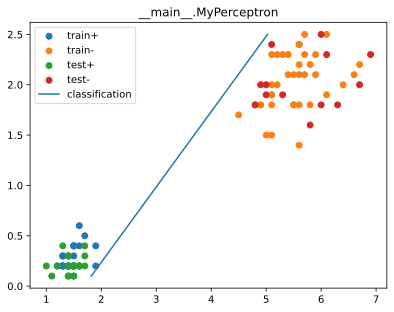

In [8]:
# | label: fig-myperceptron
# | fig-cap: "自编程实现感知机的分类效果图"

train_df_np = np.array(train_df)
validate_df_np = np.array(validate_df)
train_pos = train_df_np[:, 2] > 0
train_neg = train_df_np[:, 2] < 0
validate_pos = validate_df_np[:, 2] > 0
validate_neg = validate_df_np[:, 2] < 0
plt.scatter(train_df_np[train_pos, 0],
            train_df_np[train_pos, 1], label="train+")
plt.scatter(train_df_np[train_neg, 0],
            train_df_np[train_neg, 1], label="train-")
plt.scatter(validate_df_np[validate_pos, 0],
            validate_df_np[validate_pos, 1], label="test+")
plt.scatter(validate_df_np[validate_neg, 0],
            validate_df_np[validate_neg, 1], label="test-")
# 在分类线上找到合适尺寸的段
x_min = data[data.columns[0]].min()
x_max = data[data.columns[0]].max()
y_min = data[data.columns[1]].min()
y_max = data[data.columns[1]].max()

x_split = np.array([x_min, x_max])
y_split = \
    -(model.w[0] * x_split + model.b) / \
    model.w[1]  # 落在 x*w[0] + y*w[1] + b = 0 上的点

if y_split[0] < y_min or y_split[1] > y_max:
    y_split = np.array([y_min, y_max])
    x_split = \
        -(model.w[1] * y_split + model.b) / \
        model.w[0]  # 落在 x*w[0] + y*w[1] + b = 0 上的点

plt.title(MyPerceptron.__module__ + "." + MyPerceptron.__name__)
plt.plot(x_split, y_split, label="classification")
plt.legend()

plt.show()


## `sklearn` 实现感知机

重用上面划分的 `data` 前，要先将其转换为 `numpy` 数组。


In [9]:
from sklearn.model_selection import train_test_split
from sklearn.linear_model import Perceptron

data_np = np.array(data)
feature, label = data_np[:, :-1], data_np[:, -1]
feature_train, feature_test, label_train, label_test = train_test_split(
    feature, label, test_size=0.3, random_state=1)


注意到实验指导书中错误的禁用了 `fit_intercept` 参数，使模型误认为数据已经被中心化，从而导致模型训练失败。


In [10]:
clf = Perceptron(fit_intercept=True, max_iter=1000, shuffle=False)
clf.fit(feature_train, label_train)

print(f"迭代次数={clf.n_iter_}")
print(f"特征权重={clf.coef_} 截距（偏置）={clf.intercept_}")
print(f"训练准确率={clf.score(feature_train, label_train)}",
      f"验证准确率={clf.score(feature_test, label_test)}")


迭代次数=7
特征权重=[[-0.7 -1. ]] 截距（偏置）=[3.]
训练准确率=1.0 验证准确率=1.0


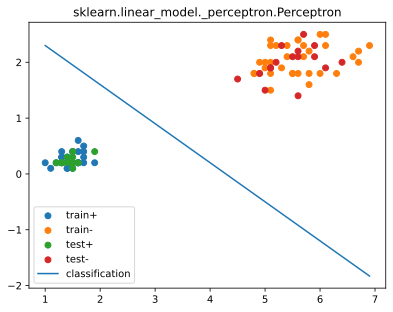

In [11]:
# | label: fig-scikit-perceptron
# | fig-cap: "sklearn 实现感知机的分类效果图"

feature_train_pos = label_train > 0
feature_train_neg = label_train < 0
feature_test_pos = label_test > 0
feature_test_neg = label_test < 0
plt.scatter(feature_train[feature_train_pos, 0],
            feature_train[feature_train_pos, 1], label="train+")
plt.scatter(feature_train[feature_train_neg, 0],
            feature_train[feature_train_neg, 1], label="train-")
plt.scatter(feature_test[feature_test_pos, 0],
            feature_test[feature_test_pos, 1], label="test+")
plt.scatter(feature_test[feature_test_neg, 0],
            feature_test[feature_test_neg, 1], label="test-")

x_split = np.array([x_min, x_max])
y_split = \
    -(clf.coef_[0, 0] * x_split + clf.intercept_[0]) / \
    clf.coef_[0, 1]  # 落在 x*w[0] + y*w[1] + b = 0 上的点

if y_split[0] < y_min or y_split[1] > y_max:
    y_split = np.array([y_min, y_max])
    x_split = \
        -(clf.coef_[0, 1] * y_split + clf.intercept_[0]) / \
        clf.coef_[0, 0]  # 落在 x*w[0] + y*w[1] + b = 0 上的点

plt.title(Perceptron.__module__ + "." + Perceptron.__name__)
plt.plot(x_split, y_split, label="classification")
plt.legend()

plt.show()


## 思考题

1. 在做数据处理时，为什么要转化为 DataFrame 格式来处理，不能直接用 NumPy 吗？

   DataFrame 不同单元格可以有不同的数据类型，还可以保留列名等信息，而 `numpy.ndarray` 只能存储同一类型的数据，且没有列名等信息，但是运算速度（与 Pandas 相比）快得多。

2. 怎样挑选合适的特征来做分类，理由是什么？

   在选出的特征中，不同类别的数据尽可能分布开来，而同一类别的数据尽可能聚集在一起，同时特征之间的相关性尽可能低。

3. 为什么要使用随机种子做数据分割？

   因为数据的分类可能与顺序有关。本次的鸢尾花数据集是一个非常极端的例子：数据都是按照三个品种顺序排列的，如果不打乱数据，那么训练集或测试集中可能只会有一种品种的数据。

4. 使用 sklearn 库来编码，学习率对迭代过程和最终结果有无影响？若有/无影响的话，条件是什么？

   在最大迭代数和收敛阈值满足的情况下，学习率对最终结果没有影响。如果最大迭代数过小或收敛阈值过低，过小的学习率可能导致模型无法收敛；如果最大迭代数过大或收敛阈值过高，过大的学习率可能导致模型收敛过快，无法达到最优解。

5. 本次实验能对 “versicolor” 和 “virginica” 两种鸢尾花做分类吗？能的话，实现出来；不能的话，说明理由。

   参考上面的 @fig-pairplot 可以看出 “versicolor” 和 “virginica” 是线性不可分的，因为它们在所有特征上都有有部分重叠。经过试验，使用 “petal length (cm)” 和 “petal width (cm)” 两个特征，仅能达到 85% 左右的准确率。
